In [152]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import time
from timm.data.mixup import Mixup

In [153]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")

In [154]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # NEW: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # NEW: Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [155]:
train_data = torchvision.datasets.CIFAR10(root = './data', download = True, train = True, transform = transform_train)
test_data = torchvision.datasets.CIFAR10(root = './data', download = True, train = False, transform = transform_test)

In [156]:
train_data_batches = DataLoader(train_data, shuffle = True, batch_size = 8, pin_memory=True)
test_data_batches = DataLoader(test_data, shuffle = True, batch_size = 8, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


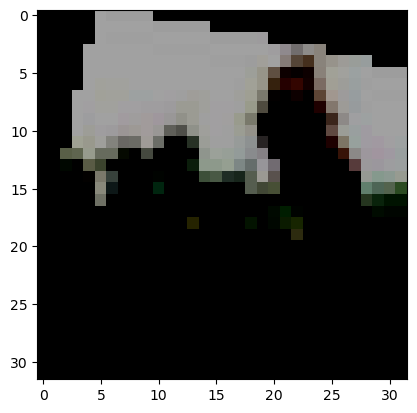

In [157]:
img, label = train_data[2] # shape is (3, 32, 32), for imshow it required (M, N, 3), so tranpose or swap it
print(img.squeeze().shape)
plt.imshow(img.permute(1, 2, 0))

In [158]:
class CIFARCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1)
        self.batch_norm4 = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, padding = 1)
        self.batch_norm5 = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, padding = 1)
        self.batch_norm6 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2,2)

        self.fc_input_size = 512 * 4 * 4 # (out_channel) X image_size / 2 (32/2 X 32/2) = 16 X 16

        self.layer1 = nn.Linear(self.fc_input_size, 512)

        self.layer2 = nn.Linear(512, 256)
        
        self.layer3 = nn.Linear(256, 10)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = self.conv5(x)
        x = self.batch_norm5(x)
        x = F.relu(x)

        x = self.conv6(x)
        x = self.batch_norm6(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(x.shape[0], -1)
        
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)

        
        x = self.layer2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.layer3(x)

        return x

In [159]:
len(train_data_batches)


6250

In [166]:
model = CIFARCNN()
model.to(device)

# loss_fn = nn.CrossEntropyLoss(label_smoothing = 0.1)


from timm.loss import SoftTargetCrossEntropy

# Use this loss function instead of CrossEntropyLoss
loss_fn = SoftTargetCrossEntropy()


epochs = 20


# Step 1: Define MixUp & CutMix augmentation
mixup_fn = Mixup(
    mixup_alpha=0.2,    # Strength of MixUp
    cutmix_alpha=1.0,   # Strength of CutMix
    prob=0.5,           # Probability of applying MixUp/CutMix
    switch_prob=0.5,    # Probability of switching between MixUp & CutMix
    mode="batch",
    num_classes=10
)

# optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9, weight_decay=0.0001)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=3e-4, steps_per_epoch=len(train_data_batches), epochs=epochs
)

t1 = time.time()
for epoch in range(epochs):
    for i, each in enumerate(train_data_batches):
        t_in = time.time()
        x_batch, y_batch = each
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        # Step 3: Apply MixUp/CutMix augmentation to the batch
        if mixup_fn is not None:
            x_batch, y_batch = mixup_fn(x_batch, y_batch)
        
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        

        if i == 0 and epoch == 0:
            CC = time.time() - t_in
            estimated_time = time_taken * len(train_data_batches) * epochs
            print("Estimated time: ", estimated_time - time_taken)
            print(estimated_time / 60)
    scheduler.step()
        
    print(f"Epoch: {epoch}, loss: {loss}")
print(time.time() - t1)

Estimated time:  777.4171624183655
12.957056363423666
Epoch: 0, loss: 2.0259804725646973
Epoch: 1, loss: 1.6528559923171997
Epoch: 2, loss: 1.3730686902999878
Epoch: 3, loss: 1.7466309070587158
Epoch: 4, loss: 1.5972508192062378
Epoch: 5, loss: 1.3533120155334473
Epoch: 6, loss: 1.6405186653137207
Epoch: 7, loss: 1.5353821516036987
Epoch: 8, loss: 1.160670518875122
Epoch: 9, loss: 0.7588609457015991
Epoch: 10, loss: 1.5277764797210693
Epoch: 11, loss: 1.2402992248535156
Epoch: 12, loss: 0.8061431050300598
Epoch: 13, loss: 0.9378387928009033
Epoch: 14, loss: 0.991340160369873
Epoch: 15, loss: 1.8778754472732544
Epoch: 16, loss: 1.0019160509109497
Epoch: 17, loss: 1.4608854055404663
Epoch: 18, loss: 0.9526244401931763
Epoch: 19, loss: 0.8463621735572815
1030.6630771160126


In [ ]:
# time taken: 9mins
# 
# 80.16, 77.6, 78

In [167]:
def check_accuracy(model, batch):
    total = 0
    correct = 0
    with torch.no_grad():
        for x_batch, y_batch in batch:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            total += y_batch.shape[0]
            _, pred_value = torch.max(y_pred, 1)
            correct += (pred_value == y_batch).sum().item()
    return correct / total * 100
t1 = time.time()
print(check_accuracy(model, test_data_batches))
print(time.time() - t1)

78.82000000000001
3.81569242477417


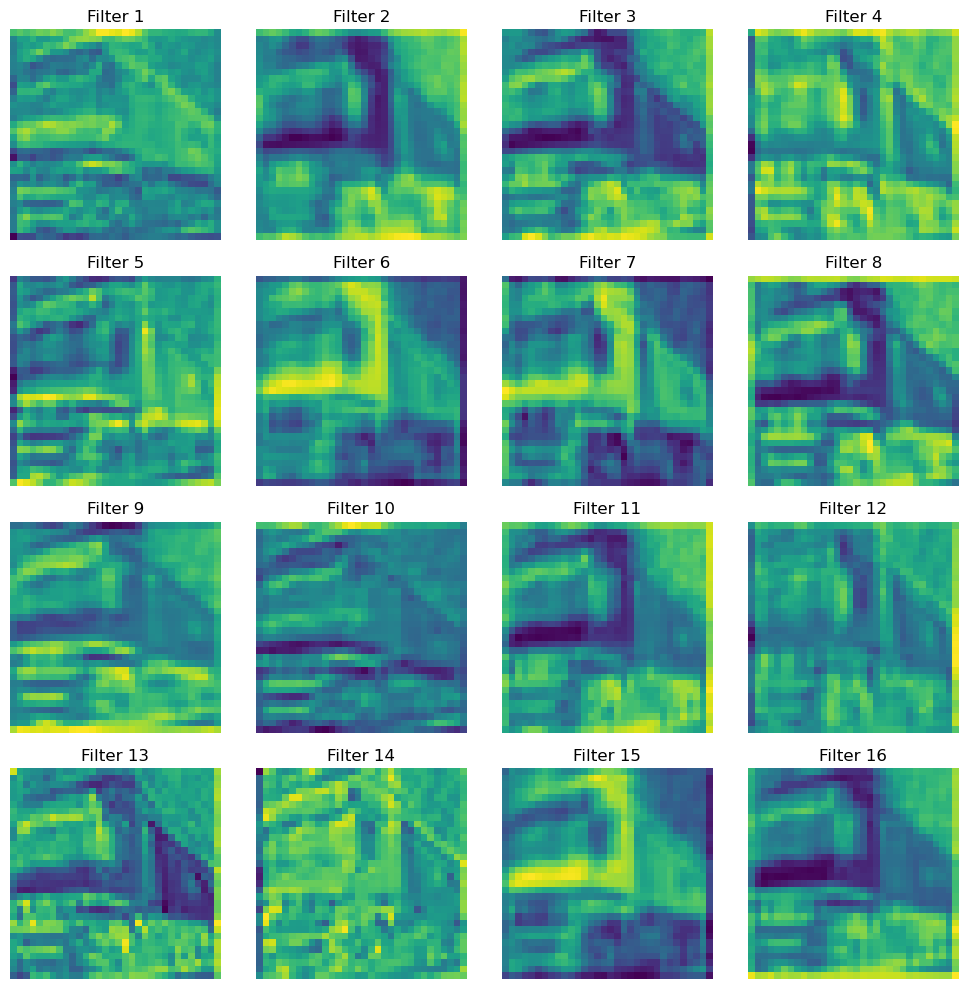

In [68]:
image, label = train_data[1]  # Taking the first image
image = image.unsqueeze(0)  # Add batch dimension (1, 1, 28, 28)

# Pass through the first convolutional layer

# Define a Conv2d layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

with torch.no_grad():
    feature_maps = conv_layer(image)  # Output shape: (1, 16, 28, 28)
    
# Convert to numpy for visualization
feature_maps = feature_maps.squeeze(0).detach().numpy()  # Shape: (16, 28, 28)

# Plot all 16 feature maps
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps[i])
    ax.axis("off")
    ax.set_title(f"Filter {i+1}")

plt.tight_layout()
plt.show()